In [1]:
import pandas as pd
import numpy as np
import tqdm 
import os
from gymnasium import spaces
import gymnasium as gym
import seaborn as sns
import matplotlib.pyplot as plt
from stable_baselines3 import PPO
from stable_baselines3 import A2C
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.evaluation import evaluate_policy
import torch 
import torch.nn as nn
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor

2024-07-06 15:52:51.824584: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-06 15:52:51.824792: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-06 15:52:51.988962: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
class Trading_env(gym.Env):
    def __init__(self, df):
        super().__init__()
        self.df = df
        self.action_space = spaces.Discrete(3)  # 0: hold, 1: buy, 2: sell
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(7,), dtype=np.float32)
        self.total_reward = 0
        self.action_counts = {0: 0, 1: 0, 2: 0}
        self.bought_at_prices = []
        self.sold_at_prices = []
        self.net_worth_list=[]
        self.final_net_worth = 0 
        self.reset()
        
    def reset(self, seed=None, options=None):
        if seed is not None:
            np.random.seed(seed)
        self.current_step = 0
        self.balance = 10000
        self.prev_net_worth = self.balance
        self.initial_balance = 10000
        self.actions = []
        self.net_worths = [self.balance]
        self.holdings = 0
        return self.get_observation(), {}
    
    def get_observation(self):
        return np.array([
            self.df.loc[self.current_step, 'Open'],
            self.df.loc[self.current_step, 'High'],
            self.df.loc[self.current_step, 'Low'],
            self.df.loc[self.current_step, 'Close'],
            self.df.loc[self.current_step, 'Volume'],
            self.balance,
            self.holdings
        ], dtype=np.float32)
    
    def step(self, action):
        self.current_price = self.df.loc[self.current_step, 'Close']
        
        reward = 0
        self.action_counts[action] += 1
        
        if action == 1:  # Buy
            max_shares = min(self.balance // self.current_price, 100)  # Limit to 100 shares per trade
            if max_shares > 0:
                bought_shares = np.random.randint(1, max_shares + 1)
                cost = bought_shares * self.current_price
                self.balance -= cost
                self.holdings += bought_shares
                self.bought_at_prices.append(self.current_price)
                reward += 0.1  # Small positive reward for buying
#                 print(f"Step {self.current_step}: Bought {bought_shares} shares at {self.current_price}")
        
        elif action == 2:  # Sell
            if self.holdings > 0:
                sold_shares = min(self.holdings, 100)  # Limit to 100 shares per trade
                revenue = sold_shares * self.current_price
                self.balance += revenue
                self.holdings -= sold_shares
                self.sold_at_prices.append(self.current_price)
                avg_buy_price = sum(self.bought_at_prices) / len(self.bought_at_prices) if self.bought_at_prices else 0
                if self.current_price > avg_buy_price:
                    reward += 1  # Positive reward for selling at a profit
                else:
                    reward -= 1  # Negative reward for selling at a loss
#                 print(f"Step {self.current_step}: Sold {sold_shares} shares at {self.current_price}")
        
        self.actions.append(action)
        self.current_step += 1
        done = self.current_step >= len(self.df) - 1
        truncated = False 
        self.net_worth = self.balance + self.holdings * self.current_price
        self.net_worths.append(self.net_worth)
        self.net_worth_list.append(self.net_worth)
        if done:
            self.final_net_worth = self.net_worth
        
        # Calculate reward based on change in net worth
        net_worth_change = (self.net_worth - self.prev_net_worth) / self.prev_net_worth
        reward += net_worth_change * 10  # Scale the reward for more pronounced feedback
        
        self.prev_net_worth = self.net_worth
        self.total_reward += reward
        
#         print(f"Step {self.current_step}: Action={action}, Reward={reward:.2f}, Net Worth={self.net_worth:.2f}")
        
        return self.get_observation(), reward, done,truncated, {
            'action': action,
            'balance': self.balance,
            'holdings': self.holdings,
            'net_worth': self.net_worth
        }
    
    def render(self):
        pass
    
    def close(self):
        pass
    
    
    def get_final_net_worth(self):
        return self.final_net_worth

    def get_total_reward(self):
        return self.total_reward

    def get_action_counts(self):
        return self.action_counts

In [3]:
def visualize_result(actions, bought_prices, sold_prices, net_worth, df):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))
    fig.suptitle('Trading Results Visualization', fontsize=16)

    # Plot 1: Market movement with buy/sell points
    ax1.set_title('Market Movement with Buy/Sell Points')
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Price')

    # Plot close price and moving average
    ax1.plot(df['Close'], label='Close Price', color='lightblue', alpha=0.6)
    df['MA50'] = df['Close'].rolling(window=50).mean()
    ax1.plot(df['MA50'], label='50-day MA', color='blue', alpha=0.8)

    # Plot buy points
    buy_indices = [i for i, price in enumerate(df['Close']) if price in bought_prices]
    ax1.scatter(buy_indices, [df['Close'][i] for i in buy_indices], 
                color='green', label='Buy', s=30, alpha=0.5)

    # Plot sell points
    sell_indices = [i for i, price in enumerate(df['Close']) if price in sold_prices]
    ax1.scatter(sell_indices, [df['Close'][i] for i in sell_indices], 
                color='red', label='Sell', s=30, alpha=0.5)

    ax1.legend(loc='upper left', bbox_to_anchor=(1, 1))

    # Set y-axis range
    y_min, y_max = df['Close'].min(), df['Close'].max()
    y_range = y_max - y_min
    ax1.set_ylim(y_min - 0.1*y_range, y_max + 0.1*y_range)

    # Plot 2: Net Worth over time
    if isinstance(net_worth, list) and len(net_worth) > 1:
        ax2.plot(net_worth, label='Net Worth', color='purple')
        ax2.set_title('Net Worth Over Time')
        ax2.set_xlabel('Time')
        ax2.set_ylabel('Net Worth')
        ax2.legend()
    else:
        print("Net worth data is not sufficient for plotting.")

    # Add text annotations for action counts
    ax1.text(0.02, 0.98, f"Hold: {actions[0]}\nBuy: {actions[1]}\nSell: {actions[2]}", 
             transform=ax1.transAxes, verticalalignment='top', 
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

    plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust layout to prevent clipping of legend
    plt.show()



In [4]:
def training_rl_model(data):
    env = DummyVecEnv([lambda: Trading_env(data)])
    model = PPO("MlpPolicy", env, verbose=1)
    model.learn(total_timesteps=10000)
    model.save("ppo_trading_model")


    # Test the trained model
    obs = env.reset()
    done = False
    actions = []
    
    while not done:
        action, _states = model.predict(obs, deterministic=True)
        obs, reward, done, info = env.step(action)
        actions.append(action[0])
        done = done[0]  # DummyVecEnv returns a list of done flags

    # Get the results from the first (and only) environment
    net_worths = env.envs[0].net_worth_list
    bought_prices = env.envs[0].bought_at_prices
    sold_prices = env.envs[0].sold_at_prices
    total_reward = env.envs[0].get_total_reward()
    action_counts = env.envs[0].get_action_counts()
    final_net_worth = env.envs[0].get_final_net_worth() 

    print(f"Total Reward: {total_reward}")
    print(f"Action Counts: {action_counts}")
    print(f"Number of buy actions: {action_counts[1]}")
    print(f"Number of sell actions: {action_counts[2]}")
    print(f"Number of hold actions: {action_counts[0]}")
    print(f"Number of bought_prices recorded: {len(bought_prices)}")
    print(f"Number of sold_prices recorded: {len(sold_prices)}")
    print(f"Final Net Worth: ${final_net_worth:.2f}")

    return action_counts, bought_prices, sold_prices, net_worths

# Usage

In [5]:
df = pd.read_csv("/kaggle/input/2016-sai/TATAMOTORS.NS (1).csv")
actions, bought_prices, sold_prices, net_worth = training_rl_model(df)

Using cpu device
-----------------------------
| time/              |      |
|    fps             | 1158 |
|    iterations      | 1    |
|    time_elapsed    | 1    |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 859         |
|    iterations           | 2           |
|    time_elapsed         | 4           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.010630823 |
|    clip_fraction        | 0.0338      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.09       |
|    explained_variance   | -1.19e-07   |
|    learning_rate        | 0.0003      |
|    loss                 | 3.89        |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.00085    |
|    value_loss           | 7.54        |
-----------------------------------------
-----------------

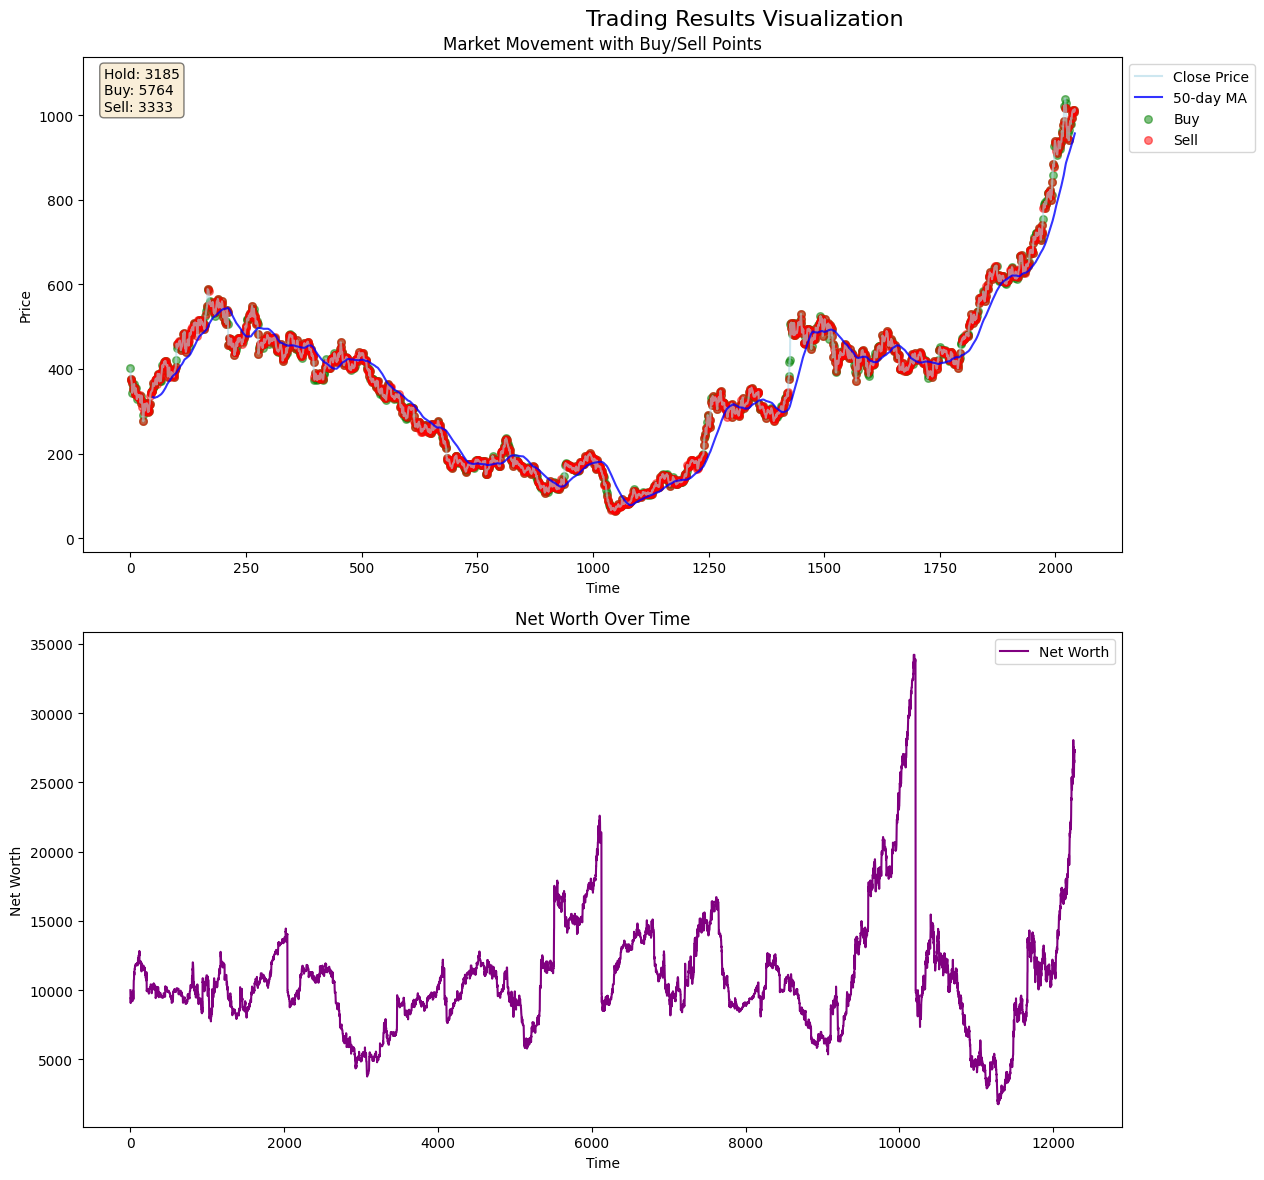

In [6]:
visualize_result(actions, bought_prices, sold_prices, net_worth, df)

In [7]:

def evaluate_rl_model(data):
    # Create the environment with the new data
    env = DummyVecEnv([lambda: Trading_env(data)])
    
    # Load the trained model
    model = PPO.load("ppo_trading_model")
    
    # Test the loaded model
    obs = env.reset()
    done = False
    actions = []
    
    while not done:
        action, _states = model.predict(obs, deterministic=True)
        obs, reward, done, info = env.step(action)
        actions.append(action[0])
        done = done[0]  # DummyVecEnv returns a list of done flags

    # Get the results from the first (and only) environment
    net_worths = env.envs[0].net_worth_list
    bought_prices = env.envs[0].bought_at_prices
    sold_prices = env.envs[0].sold_at_prices
    total_reward = env.envs[0].get_total_reward()
    action_counts = env.envs[0].get_action_counts()
    final_net_worth = env.envs[0].get_final_net_worth() 

    print(f"Total Reward: {total_reward}")
    print(f"Action Counts: {action_counts}")
    print(f"Number of buy actions: {action_counts[1]}")
    print(f"Number of sell actions: {action_counts[2]}")
    print(f"Number of hold actions: {action_counts[0]}")
    print(f"Number of bought_prices recorded: {len(bought_prices)}")
    print(f"Number of sold_prices recorded: {len(sold_prices)}")
    print(f"Final Net Worth: ${final_net_worth:.2f}")

    return action_counts, bought_prices, sold_prices, net_worths

In [8]:
df1 = pd.read_csv("/kaggle/input/validation/TATAMOTORS.NS.csv")
actions1, bought_prices1, sold_prices1, net_worth1 = training_rl_model(df1)

Using cpu device
-----------------------------
| time/              |      |
|    fps             | 1226 |
|    iterations      | 1    |
|    time_elapsed    | 1    |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 913         |
|    iterations           | 2           |
|    time_elapsed         | 4           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.012916385 |
|    clip_fraction        | 0.0949      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.09       |
|    explained_variance   | 5.96e-08    |
|    learning_rate        | 0.0003      |
|    loss                 | 4           |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.00647    |
|    value_loss           | 7.32        |
-----------------------------------------
-----------------

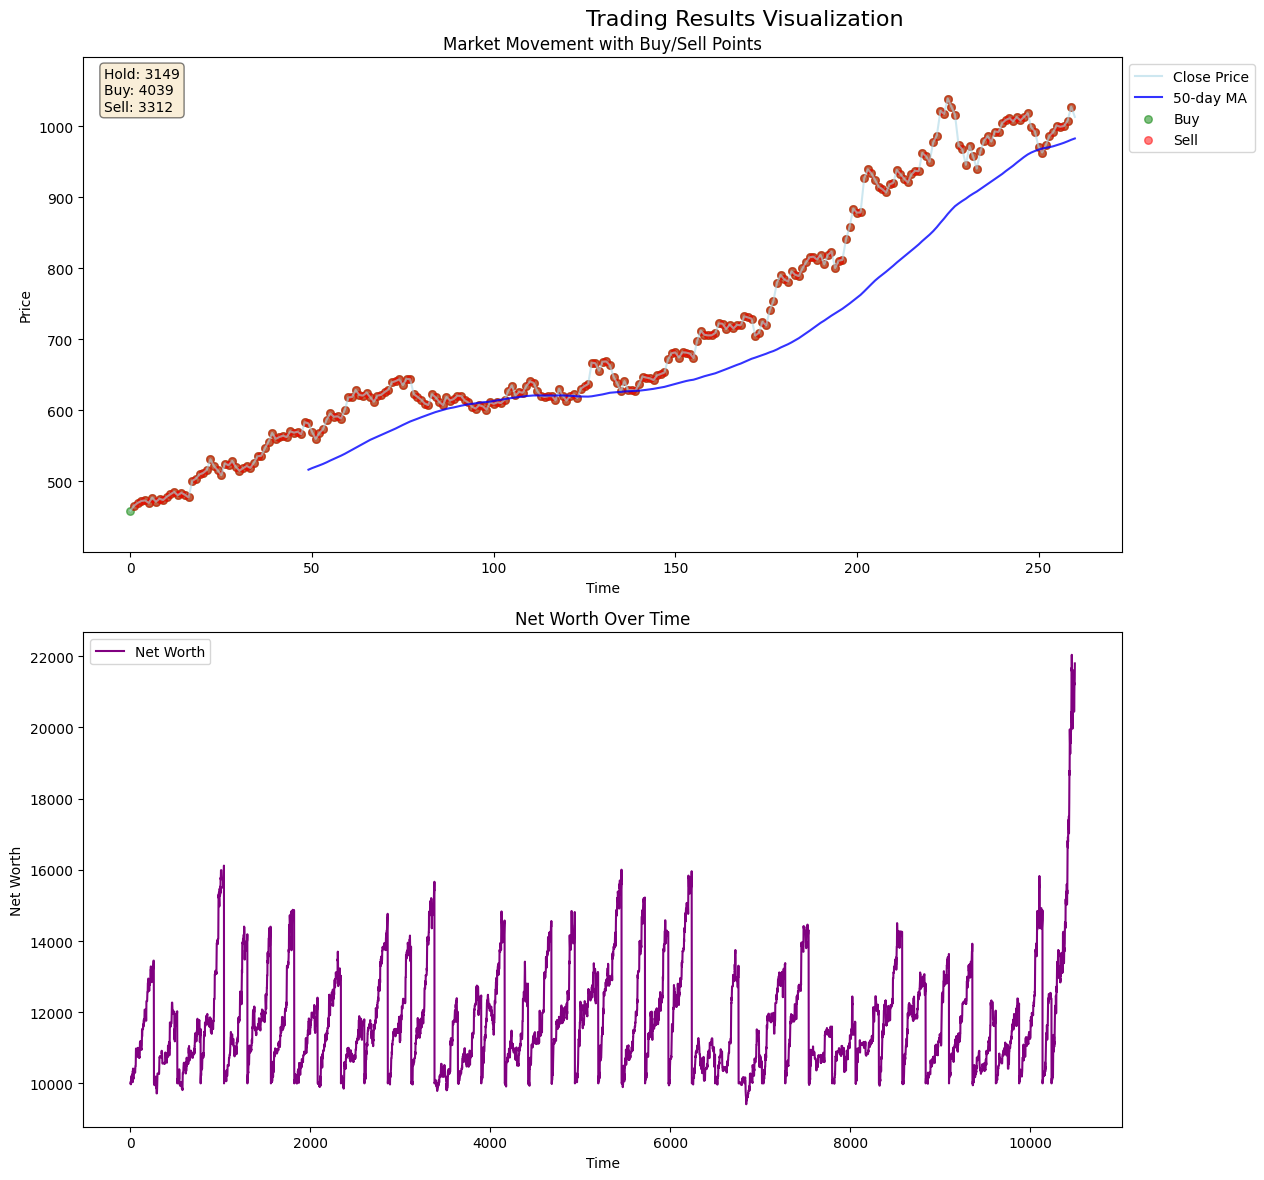

In [9]:
visualize_result(actions1, bought_prices1, sold_prices1, net_worth1, df1)